In [11]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
dataset_path = r"C:\Assignments\Frist Trimester\TEH405\Animals"

# Parameters
img_size = (128, 128)
batch_size = 32
epochs = 20


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Add brightness variation
    channel_shift_range=30.0,     # Add random shifts to the color channels
    validation_split=0.2  # Reserve a portion of data for validation
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)  

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze base model layers
base_model.trainable = False


In [6]:
# Build the model with transfer learning and L2 regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(train_generator.num_classes, activation='softmax')
])


In [7]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

C:\Users\a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3351 - loss: 1.5774

C:\Users\a\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.3352 - loss: 1.5758 - val_accuracy: 0.4350 - val_loss: 1.2449 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.3678 - loss: 1.3050 - val_accuracy: 0.5717 - val_loss: 1.1648 - learning_rate: 1.0000e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.4859 - loss: 1.1872 - val_accuracy: 0.6417 - val_loss: 1.0861 - learning_rate: 1.0000e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5235 - loss: 1.1088 - val_accuracy: 0.6900 - val_loss: 1.0086 - learning_rate: 1.0000e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.5809 - loss: 1.0303 - val_accuracy: 0.6983 - val_loss: 0.9600 - learning_rate: 1.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.6294 - loss: 0.9718 - val_accuracy: 0.7200 - val_loss: 0.9189 - learning_rate: 1.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.6535 - loss: 0.9

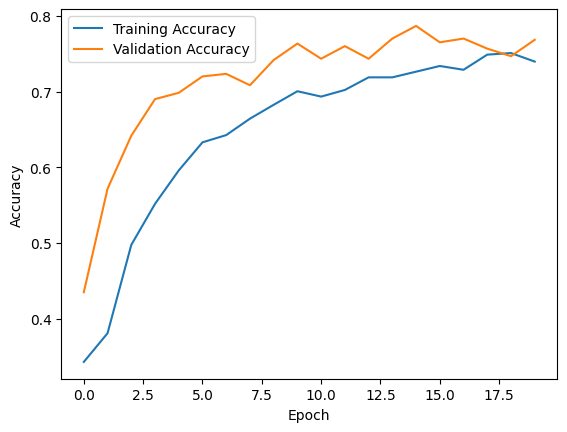

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [20]:
model.save("animal_classification_model.h5")

In [21]:
def recognize_animal_from_camera():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = cv2.resize(frame, img_size) / 255.0
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_label = list(label_map.keys())[np.argmax(predictions)]

In [31]:
import cv2
import tensorflow as tf
import numpy as np

# Load the trained model (replace with the actual path to your model file)
model = tf.keras.models.load_model('animal_classification_model.h5')

# Define the class names (Replace this list with your actual class names)
class_names = ['cats', 'dogs', 'snakes']  # Example animal names (adjust according to your dataset)

# Open the camera (0 for the default camera)
cap = cv2.VideoCapture('http://192.168.1.19:4747/video')

if not cap.isOpened():
    print("Error: Camera not found!")
else:
    while True:
        ret, frame = cap.read()  # Capture frame-by-frame
        if ret:
            # Resize the frame to the input size expected by your model (e.g., 128x128)
            img_resized = cv2.resize(frame, (128, 128))

            # Convert the image to array and preprocess (normalize the pixel values)
            img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
            img_array = img_array / 255.0  # Normalize if necessary

            # Get predictions from the model
            predictions = model.predict(img_array)
            class_index = np.argmax(predictions[0])  # Get the class with the highest probability
            class_label = class_names[class_index]  # Map the index to class label (animal name)

            # Draw the prediction text on the frame
            cv2.putText(frame, f'Prediction: {class_label}', 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (0, 255, 0), 2, cv2.LINE_AA)  # Green text

            # Display the resulting frame with the prediction
            cv2.imshow('Camera Feed - Press Q to Exit', frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Error: Could not read frame")

    cap.release()  # Release the camera
    cv2.destroyAllWindows()  # Close all OpenCV windows


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 